# Topological Overlap Matrixに基づくコミュニティ抽出
代謝ネットワークの一部（解糖系・糖新生とTCA回路）を例にして，コミュニティ検出を行います。

networkxの読み込み

In [1]:
import networkx as nx

その他ライブラリ

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict

## ネットワークの読み込み

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/eco_EM%2BTCA.txt", sep='\s+', header=None)
# グラフオブジェクトの作成
g = nx.from_pandas_edgelist(df,
                           source=df.columns[0],  # 最初の列をsourceとして使用
                           target=df.columns[1],  # 2番目の列をtargetとして使用
                           create_using=nx.Graph())  # 無向グラフとして作成

# 多重エッジと自己ループの削除（必須でないが簡単のために）
g = nx.Graph(g)  # 多重エッジを自動的に削除
g.remove_edges_from(nx.selfloop_edges(g))  # 自己ループを削除

## Topological overlap score matrixの計算

In [4]:
# ノードのリストを取得
nodes = list(g.nodes())

# 隣接行列（Aij）を得る
A_ij = nx.adjacency_matrix(g).toarray()

# Jijの計算 (共引用行列)
J_ij = np.zeros((g.number_of_nodes(), g.number_of_nodes()))
for i, node_i in enumerate(nodes):
  for j, node_j in enumerate(nodes):
    # iとjの共通の隣接ノードの数を数える
    neighbors_i = set(g.neighbors(node_i))
    neighbors_j = set(g.neighbors(node_j))
    J_ij[i,j] = len(neighbors_i.intersection(neighbors_j))

# min(ki,kj)の計算
deg = dict(g.degree())
deg_mtx = np.zeros((g.number_of_nodes(), g.number_of_nodes()))
for i, node_i in enumerate(nodes):
  for j, node_j in enumerate(nodes):
    deg_mtx[i,j] = min(deg[node_i], deg[node_j])

# Topological overlap score matrixを得る
overlap_mtx = (J_ij + A_ij) / (deg_mtx + 1 - A_ij)
np.fill_diagonal(overlap_mtx, 1)

## 階層的クラスタリングの実行

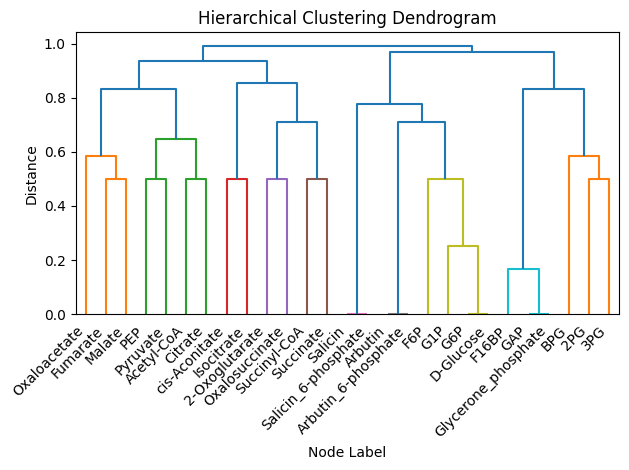

In [5]:
# 距離行列(dissimilarity score matrix)に変換
dist = squareform(1 - overlap_mtx)
# 群平均法(average)に基づいて階層的クラスタリング
linkage_matrix = linkage(dist, method='average')
# デンドログラムをプロット
dendrogram(linkage_matrix, labels=nodes)  # ラベルを追加
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Node Label')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')  # ラベルが長いので回転
plt.tight_layout()

## メンバーシップの取得

In [6]:
# k個数のコミュニティになるように分割する場合（ここでは2個に設定）
mem = fcluster(linkage_matrix, t=2, criterion='maxclust')

# heightに対する閾値hでコミュニティを決める場合は以下のよう
# mem = fcluster(linkage_matrix, t=0.9, criterion='distance')

# 各ノードのコミュニティ割り当てを表示
community_dict = dict(zip(nodes, mem))
print("Community assignments:", community_dict)

Community assignments: {'2-Oxoglutarate': 1, 'Oxalosuccinate': 1, 'Succinyl-CoA': 1, '2PG': 2, '3PG': 2, 'PEP': 1, 'BPG': 2, 'Acetyl-CoA': 1, 'Citrate': 1, 'Arbutin': 2, 'Arbutin_6-phosphate': 2, 'G6P': 2, 'GAP': 2, 'Oxaloacetate': 1, 'cis-Aconitate': 1, 'D-Glucose': 2, 'F16BP': 2, 'F6P': 2, 'Glycerone_phosphate': 2, 'Fumarate': 1, 'Malate': 1, 'Succinate': 1, 'G1P': 2, 'Isocitrate': 1, 'Pyruvate': 1, 'Salicin': 2, 'Salicin_6-phosphate': 2}


## コミュニティ検出の結果を表示

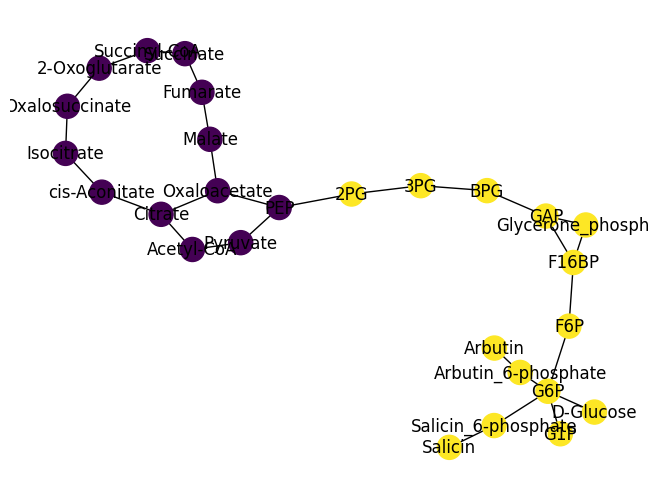

In [7]:
# コミュニティのメンバシップにしたがってノードを色付け
node_colors = [community_dict[node] for node in g.nodes()]
# ネットワーク描画
pos = nx.spring_layout(g, seed=1234)
nx.draw(g, pos=pos, with_labels=True, node_color=node_colors)

## モジュラリティ最大化による最適分割の決定

Optimal number of communities: 4
Maximum modularity: 0.6082


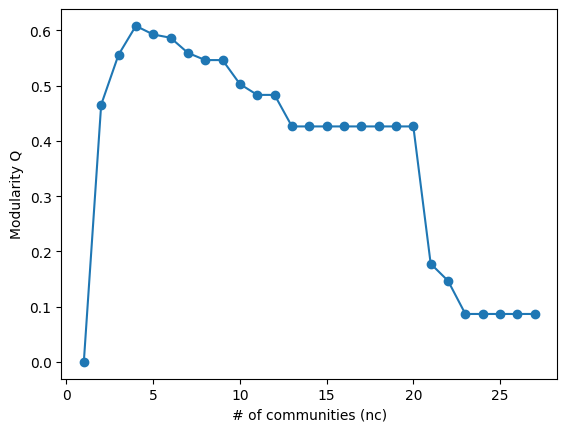

In [8]:
# モジュラリティの計算と最適なコミュニティ数の探索
q_max = float('-inf')
nc_opt = 1
nc_vs_q = []

for nc in range(1, g.number_of_nodes() + 1):
  # nc個のコミュニティに分割
  mem = fcluster(linkage_matrix, t=nc, criterion='maxclust')

  # コミュニティをNetworkXのモジュラリティ関数用に変換
  communities = defaultdict(set)
  for node, comm in zip(nodes, mem):
    communities[comm].add(node)

  # モジュラリティの計算
  q = nx.community.modularity(g, communities.values())

  nc_vs_q.append([nc, q])

  if q_max < q:
    nc_opt = nc
    q_max = q

# リストをnumpy配列に変換
nc_vs_q = np.array(nc_vs_q)

# コミュニティ数ncとその場合のモジュラリティQをプロット
plt.plot(nc_vs_q[:, 0], nc_vs_q[:, 1], 'o-')
plt.xlabel('# of communities (nc)')
plt.ylabel('Modularity Q')

print(f"Optimal number of communities: {nc_opt}")
print(f"Maximum modularity: {q_max:.4f}")

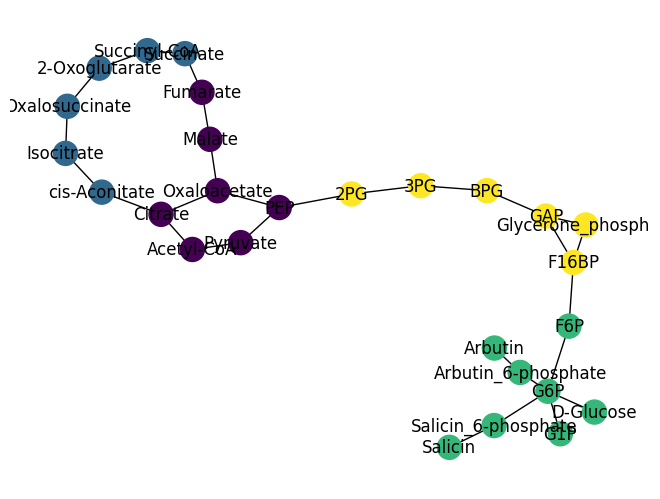

In [9]:
# モジュラリティQが最大となる分割を得る。
mem = fcluster(linkage_matrix, t=nc_opt, criterion='maxclust')
# 各ノードのコミュニティ割り当てを表示
community_dict = dict(zip(nodes, mem))
# コミュニティのメンバシップにしたがってノードを色付け
node_colors = [community_dict[node] for node in g.nodes()]
# ネットワーク描画
nx.draw(g, pos=pos, with_labels=True, node_color=node_colors)

## やってみよう
* このNotebookを参考にして，生物ネットワークを解析してみよう（``data``に様々ある）。
* Notebookを参考に自分のデータを解析してみよう。